<center>
  <font size=6 color='DarkSlateBlue'>Deep Q-Network - Reinforcement Learning with PyTorch</font>
</center>

- <font color='gray'>Reinforcement Learning - Developing Intelligent Agents</font>
- <font color='gray'>Deep Learning Course 5 of 6 - Level: Advanced</font>

- Ref: [DeepLizard – Reinforcement Learning - Developing Intelligent Agents](https://www.youtube.com/playlist?list=PLZbbT5o_s2xoWNVdDudn51XM8lOuZ_Njv)

# 📚<font size='5' color='CornflowerBlue'><a href='https://deeplizard.com/learn/video/FU-sNVew9ZA'>Project overview</a></font>

We're going to be building and training a deep Q-network to learn to balance a pole on a moving cart. This is widely known as the cart and pole problem. 

We'll be using **OpenAI's Gym** toolkit to set up our cart and pole environment. 

<center>
<img src='https://deeplizard.com/assets/svg/ac9a374b.svg'/>
<p>Image Snapped from <a href ='https://deeplizard.com/learn/video/FU-sNVew9ZA'>Deeplizard</a>
</center>

<center>
<img src='https://static.packt-cdn.com/products/9781789345803/graphics/assets/9170409d-15f1-453b-816a-6f601a89fcf2.png'/>
<p>Image Snapped from <a href ='https://subscription.packtpub.com/book/data/9781789345803/8/ch08lvl1sec46/introducing-cartpole-v1'>Packt – Hands-On Q-Learning with Python</a>
</center>


### **[CartPole-v1](https://gym.openai.com/envs/CartPole-v1/)** 

> *A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of `+1` or `-1` to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of `+1` is provided for every timestep that the pole remains upright. The episode ends when the pole is more than `15` degrees from vertical, or the cart moves more than `2.4` units from the center.*


# <font size='5' color='CornflowerBlue'>🄠-Learning Algorithm</font>

1. Initialize replay memory capacity.
2. Initialize the **policy network** with random weights.
3. Clone the **policy network**, and call it the **target network**.

4. For each episode:
  - Initialize the starting state.
  - For each time step:
    1. Select an action.
      - *Via exploration or exploitation*
    
    2. Execute selected action in an emulator.
    
    3. Observe <u>reward</u> and <u>next state</u>.
    
    4. Store experience in <u>replay memory</u>.
    
    5. Sample random batch from replay memory.
    
    6. Preprocess states from batch.
    
    7. Pass batch of preprocessed states to **policy network**.
    
    8. <u>Calculate loss</u> between output Q-values and target Q-values.
      - *Requires a pass to the **target network** for the next state*
    
    9. Gradient descent updates weights in the **policy network** to minimize loss.
             
      - *After `x` time steps, weights in the **target network** are <u>updated to the weights</u> in the **policy network**.*

# 📋<font size='5' color='CornflowerBlue'>Dependencies</font>

In [1]:
%%bash

# !apt update
apt install -y python-opengl ffmpeg > /dev/null 2>&1
# !apt install -y xvfb
pip install pyvirtualdisplay gym[atari] gym[box2d] gym[classic_control]
# WORKAROUND: retry ---v
pip install gym[box2d]
pip install --no-deps baselines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 11.0 MB/s eta 0:00:00


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [16 lines of output]
      Using setuptools (version 65.5.0).
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.linux-x86_64-cpython-38
      creating build/lib.linux-x86_64-cpython-38/Box2D
      copying library/Box2D/Box2D.py -> build/lib.linux-x86_64-cpython-38/Box2D
      copying library/Box2D/__init__.py -> build/lib.linux-x86_64-cpython-38/Box2D
      creating build/lib.linux-x86_64-cpython-38/Box2D/b2
      copying library/Box2D/b2/__init__.py -> build/lib.linux-x86_64-cpython-38/Box2D/b2
      running build_ext
      building 'Box2D._Box2D' extension
      swigging Box2D/Box2D.i to Box2D/Box2D_wrap.cpp
      swig -python -c++ -IBox2D -small -O -includeall -ignoremissing -w201 -globals b2Globals -outdir library/Box2D -keyword -w511 -D_SWIG_KWARGS -o Box2D/Box2D_wrap.cpp Box2D/Box2D.i
      error

  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py: started
Error while terminating subprocess (pid=2577): 


# <font size='4' color='DeepSkyBlue'>(A) Libraries</font>

In [ ]:
import math
import random
from typing import Text, Dict, List, NamedTuple, Tuple, Optional, Union
from collections import namedtuple
from itertools import count
from PIL import Image

import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.auto import trange

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T 
from IPython import display

**Displaying the plot inside the kernel**

In [ ]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

**Create a virtual display in the background**

In [ ]:
import pyvirtualdisplay


_display = pyvirtualdisplay.Display(visible=0,  # use False with Xvfb
                                    size=(400, 300))
_display.start()

# ⚖<font size='5' color='CornflowerBlue'>CartPole Game Dependencies</font>

# <font size='4' color='DeepSkyBlue'>(A) Simple Deep Q-network</font>

In [ ]:
class DQN(nn.Module):
    # Improve the DQN: https://deeplizard.com/learn/video/ewRw996uevN#:~:text=%20the%20first%20change%20that%20we%20need%20to%20make%20is%20to%20our%20dqn%20class.%20
    # def __init__(self, img_height, img_width):
    def __init__(self, num_state_features):
        """
        (UPDATE!)
        | Now, we're passing the state returned by the Gym environment
           as a 1-dimensional tensor with 4 elements:
          Args:
           num_state_features: [cart_position,
                                cart_velocity,
                                pole_angle,
                                pole_velocity_at_tip]
        """
        super().__init__()

        # Initialize our layers
        # self.fc1 = nn.Linear(in_features=img_height*img_width*3,
        #                      out_features=24)
        self.fc1 = nn.Linear(in_features=num_state_features,
                             out_features=32)

        self.fc2 = nn.Linear(in_features=32,
                             out_features=64)
        
        self.fc3 = nn.Linear(in_features=64,
                             out_features=128)
        
        self.out = nn.Linear(in_features=128,
                             out_features=2) # Back to the Project overview, you can
                                             # see that total possible movements
                                             # the object can do is (<left, right>)
    def forward(self, t):
        # No Longer flatten the input
        # t = t.flatten(start_dim=1) # starting from the channel matrics instead of batches
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = F.relu(self.fc3(t))
        # t = F.relu(self.out(t))
        t = self.out(t)
        return t

# <font size='4' color='DeepSkyBlue'>(B) Experience Class</font>

We're going to build the **Experience class** from **replay memory** which what we will use to train our network.

In [ ]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

**Display the experience display format**

In [ ]:
e = Experience(2, 3, 1, 4)
e

Experience(state=2, action=3, next_state=1, reward=4)

# <font size='4' color='DeepSkyBlue'>(C) Replay Memory</font>

In [ ]:
class ReplayMemeory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0

    def push(self, experience) -> None:
        """
        | This function responsible for adding experience to the
        | memory. Also used for sampling experiences from replay memory.
          IF memory less than memory initialied capacity,
            we're going to append inside the memory
          IF NOT
            we're going to begin push new experience onto the front
            of memory overwriting the oldest experience.

          Args:
            experience
        """
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
            self.push_count += 1

    def sample(self, batch_size: int):
        """Sample is equal to the `batch_size` sent to this function`"""
        return random.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size: int) -> bool:
        """
        |It tells us whether or not we can sample from memory.
          We call that the size of a sample we'll obtain from memory
          will be equal to the batch size we use to train our network.
          For example, suppose we only have 20 experiences in replay memory
          and that our batch size is 50. Then, we will be unable to sample
          because we do not have 20 experiences yet.
        """
        return len(self.memory) >= batch_size

# <font size='4' color='DeepSkyBlue'>(D) Epsilon Greedy Strategy</font>

In [ ]:
class EpsilonGreedyStrategy:
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, current_step: int) -> float:
        return self.end + (self.start - self.end) *\
                math.exp(-1. * current_step * self.decay)

# <font size='4' color='DeepSkyBlue'>(E) Agent</font>

In [ ]:
class Agent:
    def __init__(self, strategy, num_actions, device) -> None:
        """
          strategy: represent an instance from EpsilonGreedyStrategy
          num_actions: corresponding to how many possible actions
                       can the agent take from a given state.
        """
        self.strategy = strategy
        self.num_actions = num_actions
        self.current_step = 0
        self.device = device

    def select_action(self, state, policy_net) -> float:
        """
        (UPDATE!)
          The shape of our states have changed, we need to reshape the results
           returned by the network by adding one additional dimension to
           the tensor using the `unsqueeze()` function. 
        """

        epsilon_rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        # select an action
        if epsilon_rate > random.random(): # used random instead of uniform since
                                               # I don't need to end up selecting 1
                                               # at the begining.
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(device=self.device) # explore
        else:
            with torch.no_grad(): # we don't need to compute the graph (aka. gradiant track)
                                # we're just using the model for inference testing.
                # return policy_net(state).argmax(dim=1).to(self.device) # exploit
                return policy_net(state).\
                       unsqueeze(dim=0).\
                       argmax(dim=1).\
                       to(device=self.device) # exploit

# <font size='4' color='DeepSkyBlue'>(F) Environment Manager</font>

In [ ]:
class CartPoleEnvManager:
    def __init__(self, device) -> None:
        """
        (UPDATE!)
          we're no longer dealing with screen frames to determine the environment
           states, the class no longer has a `current_screen` attribute.
           Instead, we now have a `current_state` attribute, which is initialized to None. 
        """
        self.device = device
        self.env = gym.make('CartPole-v1').unwrapped # to access the tools that
                                                    # we won't access in the normal intialization
        self.env.reset() # reset the environment to get the initial observations
        self.current_screen = None # No longer available
        self.current_state = None
        self.done = False

    def reset(self) -> None:
        """
        (UPDATE!)
         Function now resets its `current_state` to the initial observation returned
          by the Gym environment when its reset, rather than resetting the screen
          as was implemented previously.
        """
        self.current_state = self.env.reset()

    def close(self) -> None:
        self.env.close()

    def render(self, mode='human'):
        return self.env.render(mode)

    def display(self):
        return self.env.display()

    def num_actions_available(self):
        """checking number of actions available in the environment –
           we have two options [<left, right>]
        """
        return self.env.action_space.n

    def take_action(self, action: torch.Tensor) -> torch.Tensor:
        """
        (UPDATE!)
          We would not store the state returned by `env.step()` since we were not
           making use of it. Now, since we're using the returned state, rather than
           the screen frames, we store the state returned by `step()`
           in the class's `current_state` attribute.
        """
        # _, reward, self.done, _ = self.env.step(action.item()) # .item() is refer to our element inside the tensor
        
        self.current_state, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)

    def get_state(self):
        """
        (UPDATE!)
          Previously, this function would return the pixel data that resulted from
           the difference of the last two screen frames rendered in the environment.
          Now, we simply return the state of the environment that we've stored in
          the class's current_state attribute. 
        """
        if self.done:
            return torch.zeros_like(
              torch.tensor(self.current_state, device=self.device)
            ).float()
        else:
            return torch.tensor(self.current_state, device=self.device).float()

    def num_state_features(self):
        """
        (NEW!)
          Returns the number of features included in a state returned by the Gym environment.
          This is so that we can know the size of states that will be passed to the
          network as input. 
        """
        return self.env.observation_space.shape[0]
    # ------------------------------------------------------------------------------
    """
    (UPDATE!)
     We no longer need any of the functions that we previously used for 
     screen processing, and so they can all be deleted. These include:
      - get_screen_height()
      - get_screen_width()
      - get_processed_screen()
      - crop_screen()
      - transform_screen_data()
      - just_starting()
    """
    def image_reset(self) -> None:
        self.env.reset()
        self.current_screen = None # for resetting the screen to the first screen 
    
    def get_image_state(self):
        """Return the current state of the environment in the form of
           a processed image of the screen.
        """
        if self.just_starting() or self.done:
            # if we're at the start of at the end of the proccess, we initialize
            # the image as a black screen.
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            # current screen
            s1 = self.current_screen
            # call a new screen (the next screen)
            s2 = self.get_processed_screen()
            # make the next screen is the current screen
            self.current_screen = s2
            # return the difference between two screens to get the current state
            return s2 - s1

    def just_starting(self) -> bool:
        """Check whether the the current screen is None or not
            This help to check if we're at the start of the environment or not!
        """
        return self.current_screen is None

    def get_screen_height(self) -> int:
        screen = self.get_processed_screen()
        return screen.shape[2]

    def get_screen_width(self) -> int:
        screen = self.get_processed_screen()
        return screen.shape[3]

    def get_processed_screen(self):
        """Get the image's color channels then transpose the channels
        into the order of channels by height and width which what PyTorch DQN expect  
        """
        screen = self.render('rgb_array').transpose((2, 0, 1))
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)

    def crop_screen(self, screen):
        """Except screen and will return a cropped version of it"""
        screen_height = screen.shape[1]

        # strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        # we cropped 40% of the top of the screen & 20% of the bottom of the screen
        screen = screen[:, top:bottom, :]

        return screen

    def transform_screen_data(self, screen):
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, # This array return contiguous array of the same as screen but transformed
                                      dtype=np.float32) / 255 # these values here will be stored sequencially in the memory
        
        screen = torch.from_numpy(screen)

        # Use `torchvision` package to compose several image transformations
        resize = T.Compose([
                           T.ToPILImage(), # Convert the image to pill image
                           T.Resize((40,90)), # resize the image to 40x90
                           T.ToTensor() # convert it to tensor
        ])
        # Unsqueeze should add another dimension which represents the batch dim
        ## since the processed images will be passed to the dqn in batches.
        return resize(screen).unsqueeze(0).to(self.device)
  

## Example of non-processed screen

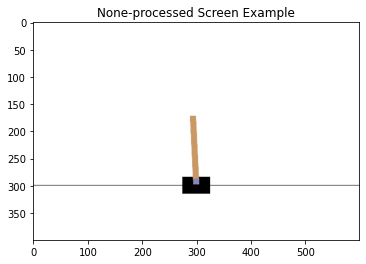

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_em = CartPoleEnvManager(device)
image_em.image_reset()
screen = image_em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title('None-processed Screen Example')
plt.show()

## Example of processed screen

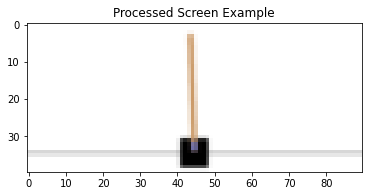

In [ ]:
screen = image_em.get_processed_screen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0).cpu(), interpolation='none')
plt.title('Processed Screen Example')
plt.show()

## Example of starting state

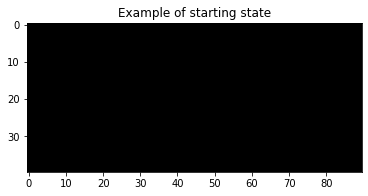

In [ ]:
screen = image_em.get_image_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0).cpu(), interpolation='none')
plt.title('Example of starting state')
plt.show()

## Example of None-starting state

This shape due to taking the differences between the first and the second screen

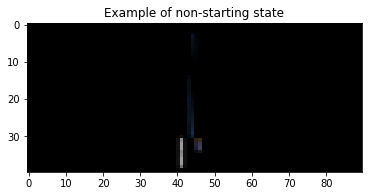

In [ ]:
for i in range(5):
    image_em.take_action(torch.tensor([1]))
screen = image_em.get_image_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0).cpu(), interpolation='none')
plt.title('Example of non-starting state')
plt.show()

## Example of End state

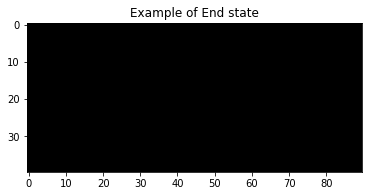

In [ ]:
image_em.done = True
screen = image_em.get_image_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0).cpu(), interpolation='none')
plt.title('Example of End state')
plt.show()

# <font size='4' color='DeepSkyBlue'>(G) Utility Functions</font>

### Tensor Processing

In [ ]:
def extract_tensors(experiences: NamedTuple) -> Tuple[torch.TensorType]:
    """
    | accepts a batch of Experiences and first transposes
    it into an Experience of batches.
    """
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    """
    (UPDATE!)
    In our `extract_tensors()` utility function, now that the states
     are 1-dimensional, we need to `stack` the `states` and `next_states` along a new axis,
     rather than concatenate (`cat`) them along an existing axis,
     as we were doing previously when our states were 4-dimensional (`BCHW`). 
    """
    # t_states = torch.cat(batch.state)
    t_states = torch.stack(batch.state)
    t_actions = torch.cat(batch.action)
    # t_next_state = torch.cat(batch.next_state)
    t_next_state = torch.stack(batch.next_state)
    t_rewards = torch.cat(batch.reward)


    return (t_states,
            t_actions,
            t_next_state,
            t_rewards)

#### **Example of `Experience(*zip(*experiences))` used above**



In [ ]:
e1 = Experience(1,1,1,1)
e2 = Experience(2,2,2,2)
e3 = Experience(3,3,3,3)

experiences = [e1,e2,e3]
experiences

[Experience(state=1, action=1, next_state=1, reward=1),
 Experience(state=2, action=2, next_state=2, reward=2),
 Experience(state=3, action=3, next_state=3, reward=3)]

Now, let's illustrate that in a form of `batch` instead of having it a form of `samples`.

In [ ]:
batch = Experience(*zip(*experiences))
batch

Experience(state=(1, 2, 3), action=(1, 2, 3), next_state=(1, 2, 3), reward=(1, 2, 3))

### Q-Value Calculator

In [ ]:
class QValues:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    @staticmethod
    def get_current(policy_net, states, actions):
        """
        | his function accepts a `policy_net`, `states`, and `actions`.
        | When we call this function in our main program, recall that these `states`
          and `actions` are the state-action pairs that were sampled from replay memory.
          So, the states and actions correspond with each other. 
        """
        # Ensure that each prediction corresponting to each action in the batch
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))

    @staticmethod
    def get_next(target_net, next_states):
        """
        | This function accepts a `target_net` and `next_states`.
        | Recall that for each next state, we want to obtain the maximum 
          q-value predicted by the `target_net` among all possible next actions. 
        | Link to the description: https://deeplizard.com/learn/video/ewRw996uevM#:~:text=this%20function%20accepts%20a%20target_net%20and%20next_states.%20recall%20that%20for%20each%20next%20state%2C%20we%20want%20to%20obtain%20the%20maximum%20q-value%20predicted%20by%20the%20target_net%20among%20all%20possible%20next%20actions.%20
        """
        # find the locations of all the final states. If an episode is ended by a given action
        ## we're finding the locations of these final states so that 
        ## we know not to pass them to the target_net for q-value predictions
        ## when we pass our non-final next states.
        final_states_location = next_states.flatten(start_dim=1)\
          .max(dim=1)[0].eq(0).type(torch.bool) #check each individual next state tensor to find its maximum value.
          ## If its maximum value is equal to `0`, then we know that this particular next state
          ## is a final state, and we represent that as a `True` within this `final_state_locations` tensor.
          ## next_states that are not final are represented by a `False` value in the tensor.
        non_final_states_locations = (final_states_location == False)

        # Now that we know the locations of the non-final states,
        ## we can now get the values of these states by indexing into the `next_states` tensor
        ## and getting all of the corresponding non_final_states.
        non_final_states = next_states[non_final_states_locations]

        # Next, we find out the batch_size by checking to see how many next states
        ## are in the `next_states` tensor. Using this, we create a new tensor of `zeros`
        ## that has a length equal to the batch size.
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)

        # We then index into this tensor of zeros with the `non_final_state_locations`,
        ## and we set the corresponding values for all of these locations
        ## equal to the maximum predicted `q-values` from the `target_net` across each action.
        values[non_final_states_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        # Ref: https://stackoverflow.com/a/56817594/14473118
        ## torch.Tensor.detach() –  creates a tensor that shares storage with tensor that does not require grad.

        # Return maximum predicted q-value across all actions for each non-final state.
        ## (aka. Maximum Expected rate)
        return values

### Moving Average Plot

To solve cart and pole, the average reward must be greater than or equal to `195` over <u>`100` consecutive episodes</u>. Recall that our agent gets a reward of `+1` for each step it takes that doesn't end the episode. So, the duration of an episode measured in timesteps is exactly equivalent to the reward for that episode. 

In [ ]:
def plot(values, # Episode Durations
         moving_avg_period,
         env=None): # 100 episodes moving average
    moving_avg = get_moving_average(moving_avg_period, values)
    # plt.figure(2)
    figure, axes = plt.subplots(1, 2, figsize=(21, 6),
                              gridspec_kw={'width_ratios': [4, 6],
                                           'wspace':0.025, 'hspace':0.025})

    plt.subplots_adjust(wspace=0, hspace=0)
    # plt.clf()
    axes[0].set_title('Training...')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Duration')
    axes[0].plot(values)
    axes[0].plot(moving_avg)
    if env:
        axes[1].set_title('Cart Pole Rendering')
        axes[1].grid(False)
        axes[1].set_xticks([])
        axes[1].set_yticks([])
        axes[1].imshow(env.render('rgb_array'))
    else:
        axes[1].set_axis_off()
    plt.pause(0.001)
    print(f"- Episodes: {len(values)}\n- {moving_avg_period} episodes moving avg: {moving_avg[-1]}")
    if is_ipython: display.clear_output(wait=True)

In [ ]:
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)

    if len(values) >= period: # we can't calculate moving average of a dataset
                            ## when the dataset is not at least as large as the
                            ## the period we want to caculate the moving average for

        moving_avg = values.unfold(dimension=0, # which returns a tensor that contains 
                                   size=period, # with a size equal to the period 
                                   step=1)\
                                   .mean(dim=1).flatten(start_dim=0)
                                   # containing all slices of 100 accross the original value tensor 
                                   ## taking the average of each of these slices
                                                        ## and flatten the tensor so that now
                                                        ## a moving average is equal to tensor
                                                        ## containing all 100 period moving average.

        # We then concatenate this resulting tensor to a tensor of zeros with a size
        ## equal to `period-1`. This is to show that the moving average for the first 
        ## `period-1` values is zero given the explanation we just gave a moment ago.
        ## So, if our period is `100`, then the first `99` values of the moving_avg
        ## tensor will be `0`, and then each value afterwards will be the actual 
        ## calculated `100-period` moving average. 
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        # if the values is not bigger of equal to the period
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()    

**Example for plotting values**

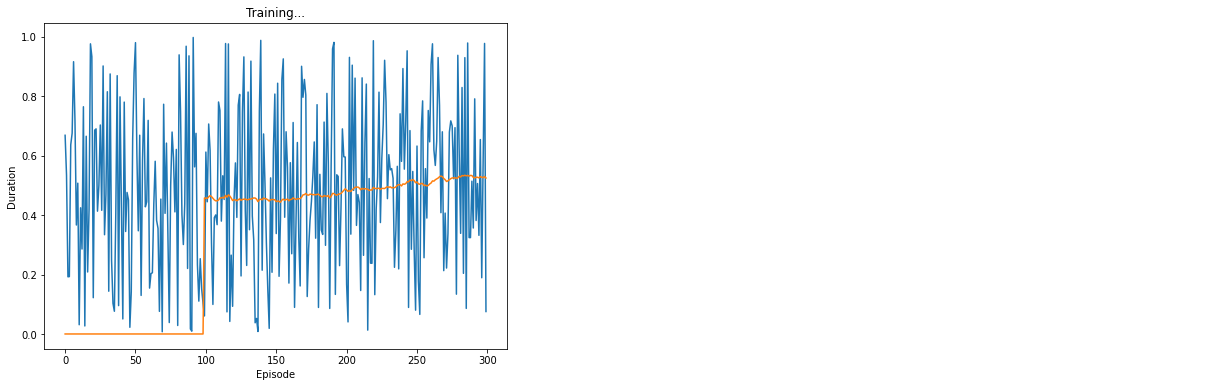

- Episodes: 300
- 100 episodes moving avg: 0.5249742865562439


In [ ]:
plot(np.random.rand(300), 100)

 The actual values are plotted in blue, and the orange line is the `100-period` moving average across these values.

We can see that the `100-period` moving average is `0` for the first `99` values, and then we get the first calculated moving average at the `100th` value. This represents the average of the first `100` values in the array. If we skip over to the moving average at value `200`, then the orange line at this point represents the average of the second `100` values between value `100` to `200`. 

# <font size='4' color='DeepSkyBlue'>(H) Main Program</font>

### Global Hyperparameters

In [ ]:
batch_size = 256
gamma = 0.999 # --> discounted rate
eps_start = 1 # --> Epsilon start
eps_end = 0.01 # --> Epsilon end
eps_decay = 0.001 # --> rate of Epsilon decay
target_update = 10 # --> For every 10 episode, we're going to update 
                         ## the target network with the policy network weights
# 1. Initialize replay memory capacity. 
memory_size = 100000
lr = 0.001
num_episodes = 1000

### Main objects

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemeory(memory_size)

# 2. Initialize the policy network with random weights. 
# policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
policy_net = DQN(em.num_state_features()).to(device)

# 3. Clone the policy network, and call it the target network. 
# target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.num_state_features()).to(device)

### Updating the policies

Get the `target_network` weights from `policy_network` wieghts

In [ ]:
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

Evaluate the `target_network` – also, we're telling the network that this network is not on the training mode, in other words it is only used in inference.

In [ ]:
target_net.eval()

DQN(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=2, bias=True)
)

Update the weights in the `policy_network`

In [ ]:
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

### Training Mode

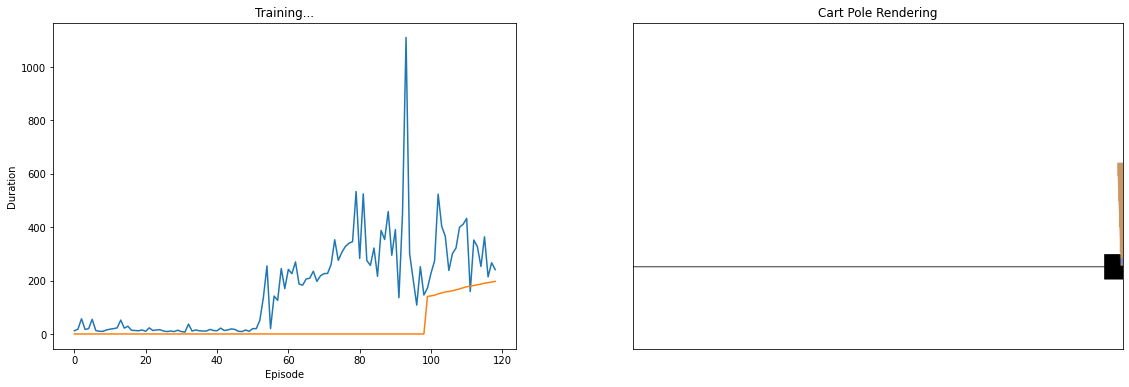

- Episodes: 119
- 100 episodes moving avg: 197.07000732421875


In [ ]:
episode_duration = []

# 4. For each episode:
for episode in range(num_episodes):
    em.reset()
    # (4.1) Initialize the starting state.
    state = em.get_state()
    # (4.2) For each time step:
    for timestep in count():
        """
        (UPDATE!)
          We've now added a line to our main program's nested timestep loop to `render()`
           the environment to the screen. Previously, the call to `render()` was nested
           inside one of the `CartPoleEnvManager`'s screen processing functions 
           `get_processed_screen()` that we no longer utilize. 
        """
        em.render()
        # (4.2.1) Select an action.
        action = agent.select_action(state, policy_net)
        # (4.2.2) Execute selected action in an emulator.
        # (4.2.3) Observe reward and next state.
        reward = em.take_action(action)
        next_states = em.get_state()
        # (4.2.4) Store experience in replay memory.
        memory.push(Experience(state, action, next_states, reward))
        state = next_states

        # (4.2.5) Sample random batch from replay memory.
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            # (4.2.6) Preprocess states from batch.
            states, actions, next_states, rewards = extract_tensors(experiences)
            # (4.2.7) Pass batch of preprocessed states to policy network.
            # Get the current Q-values of the policy net and the next Q-values for the target nework 
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            # calculate the target Q-values (aka. Bellman Optimality Equation)
            target_q_values = rewards + (gamma * next_q_values)

            # (4.2.8) Calculate loss between output Q-values and target Q-values.
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))

            # (4.2.9) Gradient descent updates weights in the policy network to minimize loss.
            ## Calculate the gradients of the loss
            loss.backward()
            ## Update the network with the gradients
            optimizer.step()
            ## Reset the gradients weights & biases before back propagation
            optimizer.zero_grad()

        # Check if the agent took the last action in the episode 
        if em.done:
            episode_duration.append(timestep)
            plot(episode_duration, 100, em) # plot the duration by 100 moving average
            break

    # (4.2.9.1) After *x* time steps,
    ## weights in the target network are updated to the weights in the policy network.
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    """
    (UPDATE!)
    We've added one line to the end of the episode loop to end the program
     if the network solves the environment by reaching the `100-episode` average reward
     of 195 or higher. 
    """
    if get_moving_average(100, episode_duration)[-1] >= 195:
        break

em.close()

The goal is to reach the `195` moving average in a short amount of time. Previously, while I was using the **image processing** approach with DNN – I was not able to reach the `195` moving average in `1000` episodes. Now, After using **Positioning Features**. I have reached this required moving average in `119` episodes.

<center>
    <img src="https://i.imgur.com/0rqP23F.png"/>
</center>


So, is this the only solution we can apply?

- Of course not. We can try different approaches such as enhancing the image processing by using a more advanced network which is using CNN, Transfer Learning, Image Augmentations, and other approaches that can define this optimization problem. I tried to change the gradient calculation using **Huber** instead of **MSE**. It didn't give me the speed or the required score, too. We can try using Adam Weight Optimization for having a much better learning rate for having a quicker, or a slower abundance of the values in the **Replay Memory**. 

<p style='background:LawnGreen;
          border-radius: 25px;
          padding: 20px;
          color:ForestGreen;
          font-size:21px;
          border: 2px solid Lavender;
          text-align:center'><b>I would be more than happy If you share with me your thoughts in the comments section!!!</b></p>

<center>
________________________________
</center>

<p style='text-align:center;'>Thanks for reaching this level of expermenting
the idea of</p>
<center><p style='text-align:center;'><b>Deep Q-Network - Reinforcement Learning</b></p></center>
<p style='text-align:center;'>AI Engineer: <a href='https://www.linkedin.com/in/drxavier997/'>Ahmed</a></p>
<p style='text-align:center;'>Created at: 2022-02-21<br>